## Bayesian Entropy NN - 1D Regression Section


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
# import seaborn as sns


from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [15]:
# create directory for tensorboard logs
import os
if not os.path.exists('benn_1d_regression_section'):
    os.makedirs('benn_1d_regression_section')
    


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [17]:
# set folder to save results 
folder = 'results_benn_1d_regression'
if not os.path.exists(folder):
    os.makedirs(folder)

### Training Dataset

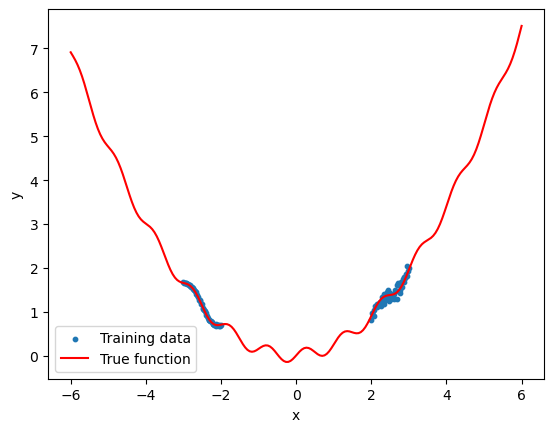

In [18]:
import numpy as np
# Training data
'''
The training data is a polynomial function with noise added to it. 
There are two regions of training data, the first from x = 5 to x = 10
and the second from x = 30 to x = 35. The first one has sigma = 1 
and the second one has sigma = 3.
'''
# Training data
np.random.seed(0)
p0,p1,p2 = 0.2,0.05,0.01
a1 = 0.25
x1 = np.linspace(-3, -2, 50)
y1 =np.polyval([p0,p1,p2], x1) + 0.15*np.sin(2*np.pi*x1) + np.random.normal(0, 0.01, len(x1))

x2 = np.linspace(2.0, 3.0, 50)
y2 = np.polyval([p0,p1,p2], x2) + 0.15*np.sin(2*np.pi*x2) + np.random.normal(0, 0.1, len(x2))

X_train = np.concatenate((x1, x2))
y_train = np.concatenate((y1, y2))

# true function
x_true = np.linspace(-6, 6, 200)
y_true = np.polyval([p0,p1,p2], x_true) + 0.15*np.sin(2*np.pi*x_true)

# Plot the training data
plt.scatter(X_train, y_train, s=10, label='Training data')
plt.plot(x_true, y_true, 'r', label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# Create dataloader for regression task
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, shuffle=True)


### Baseline BNN

In [19]:
# Periodic Activation Function
class PeriodicActivationFunction(nn.Module):
    def __init__(self, d):
        super(PeriodicActivationFunction, self).__init__()
        # d is the number of terms
        self.d = d
        for i in range(d):
            setattr(self, f'w{i}', nn.Parameter(torch.randn(1)))
            setattr(self, f'b{i}', nn.Parameter(torch.randn(1)))
        
    def forward(self, x):
        result = 0
        for i in range(self.d):
            w = getattr(self, f'w{i}')
            b = getattr(self, f'b{i}')
            result += torch.sin(w*x + b)
        return result



In [20]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 100, bias = True, 
                                       prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')), 
                                                                               torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = 0.0, posterior_rho_init = -7)
        self.blinear2 = BayesianLinear(100, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),
                                                                                                              torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = 0.0, posterior_rho_init = -7)
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        x = self.blinear2(x_)
        
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))

        return x_pred, x_log_noise
    


In [21]:
regressor_bnn = BayesianRegressor(1, 2).to(device)
opt_bnn = optim.Adam(regressor_bnn.parameters(), lr=1e-3)
criterion = nn.GaussianNLLLoss()

In [22]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_bnn.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        if torch.isnan(loss_total).item():
            print('Loss is NaN at iteration:', i)
            break

        if loss_data.item() < best_loss:
            # check if loss is nan
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model = regressor_bnn
            print('Best model updated at epoch:', epoch)


        opt_bnn.zero_grad()
        loss_total.backward()
        opt_bnn.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())


Best model updated at epoch: 0
Epoch: 0 Total Loss: 26.549854278564453 Likelihood Loss: 0.7561975121498108 Complexity Loss: 25.793657302856445
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 26.600862503051758 Likelihood Loss: 0.4451676905155182 Complexity Loss: 26.15569496154785
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model updated at epoch: 14
Best model updated at epoch: 15
Best model updated at epoch: 16
Best model updated at epoch: 17
Best model updated at epoch: 18
Best model updated at epoch: 19
Best model updated at epoch: 20
Epoch: 20 Total Loss: 26.32251739501953 Likelihood Loss: 0.2479630559682846 Complexity Loss: 26.074554443359375
Be

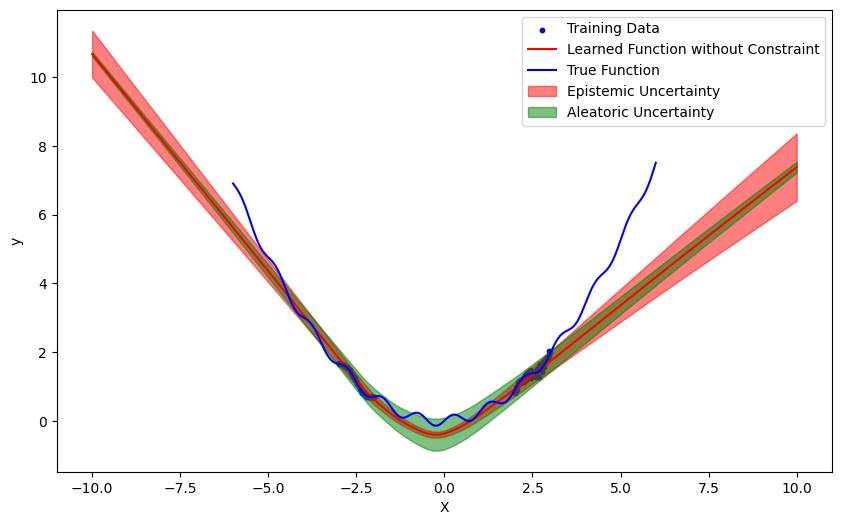

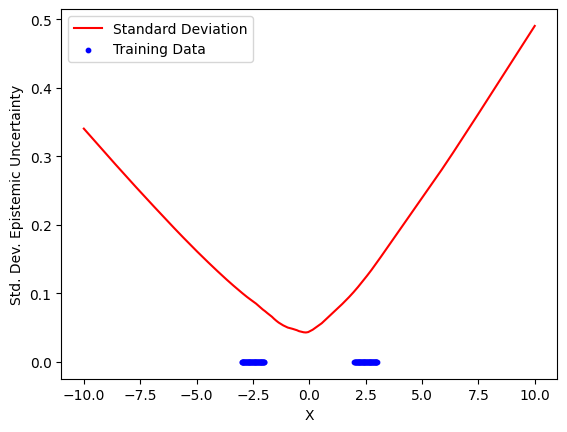

In [10]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
x_plot = torch.linspace(-10, 10, 200).reshape(-1,1)

# preds_benn = [best_model_benn(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
# preds_benn = np.stack(preds_benn)
# mean_benn = preds_benn.mean(axis=0)
# ale_benn = best_model_benn(x_plot.to(device))[1].cpu().detach().numpy()
# std_benn = preds_benn.std(axis=0)
# ci_upper_benn = mean_benn + (3*std_benn)
# ci_lower_benn = mean_benn - (3*std_benn)
preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds)
mean = preds.mean(axis=0)
ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()
ale_std = ale**0.5

std = preds.std(axis=0)
std = std
# compute the slope of the std 
slope_std = np.diff(std.squeeze())/np.diff(x_plot.squeeze())
# print it from x >= 2

ci_upper_ale = mean + (2*ale_std)
ci_lower_ale = mean - (2*ale_std)

ci_lower = mean - (2*std)
ci_upper = mean + (2*std)


# plt.plot(x_plot, mean_benn, color='black', label='Learned Function with BENN Constraint')
# plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='black', alpha=0.5)
plt.plot(x_plot, mean, color='red', label='Learned Function without Constraint')
plt.plot(x_true, y_true, color = 'blue', label='True Function')
plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5, label = 'Epistemic Uncertainty')
plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='green', alpha=0.5, label = 'Aleatoric Uncertainty')
plt.xlabel('X')
plt.ylabel('y')
# plt.xlim(-10, 10)
plt.legend()
plt.show()
# compute the derivative of std with respect to x_plot
slope_std = np.gradient(std.squeeze(), x_plot.squeeze())

# plot std vs x_plot
plt.plot(x_plot, std, color='red', label='Standard Deviation')
# fill_between the training data range - a vertical line
# plt.axvline(x = X_train.min(), color = 'black', linestyle = '--', label = 'Training Data Range')
# plt.axvline(x = X_train.max(), color = 'black', linestyle = '--')
# plot training data as 'x's
plt.scatter(X_train,np.zeros_like(X_train), color='blue', label='Training Data', s=10)
plt.xlabel('X')
plt.ylabel('Std. Dev. Epistemic Uncertainty')
plt.legend()
plt.show()


### BENN WITH UNIFORM PRIOR


In [10]:
@variational_estimator
class UniformPriorHeteroscedasticRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 uniform_low = -25.0, uniform_high = 25.0, 
                 posterior_mu_init = 0.0, posterior_rho_init = -7.0):
        super().__init__()
        # Layers for prediction
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 100, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.ReLU(),
            BayesianLinear(100, output_dim, bias=True,
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise


In [11]:
regressor_bnn_uniform = UniformPriorHeteroscedasticRegressor(1, 2).to(device)
opt_bnn_uniform = optim.Adam(regressor_bnn_uniform.parameters(), lr=1e-3)
criterion = nn.GaussianNLLLoss()

In [12]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_bnn_uniform.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        if loss_data.item() < best_loss:
            # check if loss is nan
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model_uniform = regressor_bnn_uniform
            print('Best model updated at epoch:', epoch)

        opt_bnn_uniform.zero_grad()
        loss_total.backward()
        opt_bnn_uniform.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())

Best model updated at epoch: 0
Epoch: 0 Total Loss: 39.38017272949219 Likelihood Loss: 1.233998417854309 Complexity Loss: 38.146175384521484
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 39.01615905761719 Likelihood Loss: 0.8375536203384399 Complexity Loss: 38.17860412597656
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model updated at epoch: 14
Best model updated at epoch: 15
Best model updated at epoch: 16
Best model updated at epoch: 17
Best model updated at epoch: 18
Best model updated at epoch: 19
Best model updated at epoch: 20
Epoch: 20 Total Loss: 38.613643646240234 Likelihood Loss: 0.5709989666938782 Complexity Loss: 38.04264450073242
Best 

In [14]:
regressor_bnn_uniform_wide = UniformPriorHeteroscedasticRegressor(1, 2, uniform_low = -100, uniform_high = 100).to(device)
opt_bnn_uniform_wide = optim.Adam(regressor_bnn_uniform_wide.parameters(), lr=1e-3)
criterion = nn.GaussianNLLLoss()

In [15]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_bnn_uniform_wide.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        if loss_data.item() < best_loss:
            # check if loss is nan
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model_uniform_wide = regressor_bnn_uniform_wide
            print('Best model updated at epoch:', epoch)

        opt_bnn_uniform_wide.zero_grad()
        loss_total.backward()
        opt_bnn_uniform_wide.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())

Best model updated at epoch: 0
Epoch: 0 Total Loss: 45.212059020996094 Likelihood Loss: 1.3732707500457764 Complexity Loss: 43.83878707885742
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 44.424293518066406 Likelihood Loss: 0.8367338180541992 Complexity Loss: 43.58755874633789
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model updated at epoch: 14
Best model updated at epoch: 15
Best model updated at epoch: 16
Best model updated at epoch: 17
Best model updated at epoch: 18
Best model updated at epoch: 19
Best model updated at epoch: 20
Epoch: 20 Total Loss: 44.17242431640625 Likelihood Loss: 0.48535647988319397 Complexity Loss: 43.687068939208984
Be

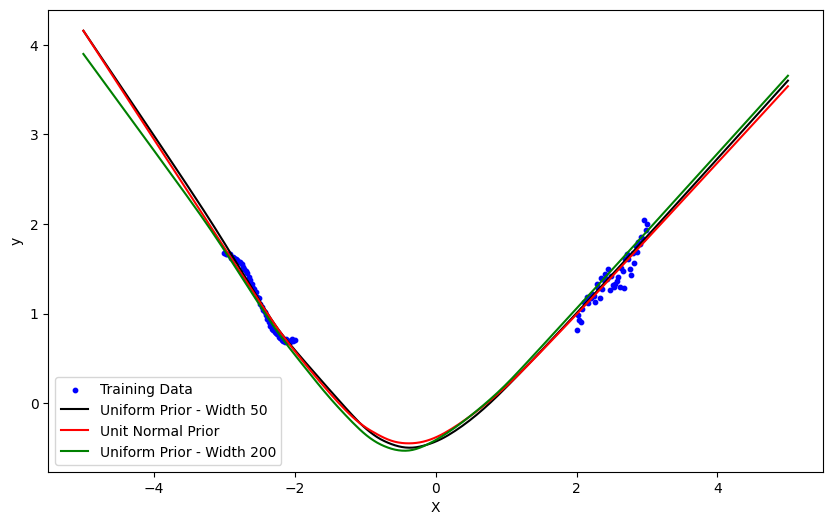

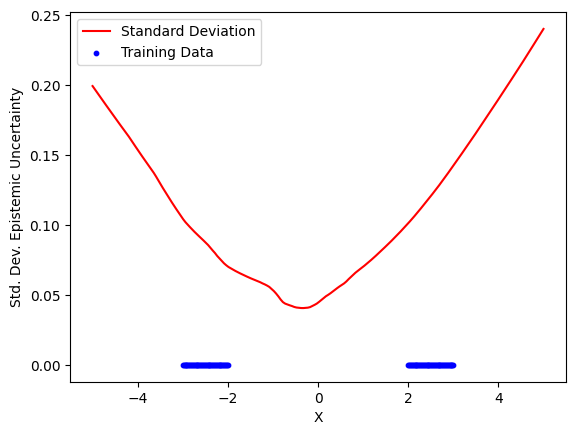

In [17]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
x_plot = torch.linspace(-5, 5, 200).reshape(-1,1)

preds_uniform = [best_model_uniform(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_uniform = np.stack(preds_uniform)
mean_uniform = preds_uniform.mean(axis=0)
ale_uniform = best_model_uniform(x_plot.to(device))[1].cpu().detach().numpy()**0.5
std_uniform = preds_uniform.std(axis=0)
ci_upper_uniform = mean_uniform + (std_uniform)
ci_lower_uniform = mean_uniform - (std_uniform)
ci_upper_ale_uniform = mean_uniform + (ale_uniform)
ci_lower_ale_uniform = mean_uniform - (ale_uniform)

# preds from bnn
preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds)
mean = preds.mean(axis=0)
ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()**0.5
std = preds.std(axis=0)
ci_upper = mean + (std)
ci_lower = mean - (std)
ci_upper_ale = mean + (ale)
ci_lower_ale = mean - (ale)

# preds from uniform wide
preds_uniform_wide = [best_model_uniform_wide(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds_uniform_wide)
mean_uniform_wide = preds.mean(axis=0)
ale_uniform_wide = best_model_uniform_wide(x_plot.to(device))[1].cpu().detach().numpy()**0.5
std_uniform_wide = preds.std(axis=0)
ci_upper_uniform_wide = mean_uniform_wide + (std_uniform_wide)
ci_lower_uniform_wide = mean_uniform_wide - (std_uniform_wide)
ci_upper_ale_uniform_wide = mean_uniform_wide + (ale_uniform_wide)
ci_lower_ale_uniform_wide = mean_uniform_wide - (ale_uniform_wide)

plt.plot(x_plot, mean_uniform, color='black', label='Uniform Prior - Width 50')
# plt.fill_between(x_plot.squeeze(), ci_lower_uniform.squeeze(), ci_upper_uniform.squeeze(), color='black', alpha=0.5, label = 'Epistemic Uncertainty')
# plt.fill_between(x_plot.squeeze(), ci_lower_ale_uniform.squeeze(), ci_upper_ale_uniform.squeeze(), color='yellow', alpha=0.5, label = 'Aleatoric Uncertainty')
plt.plot(x_plot, mean, color='red', label='Unit Normal Prior')
plt.plot(x_plot, mean_uniform_wide, color='green', label='Uniform Prior - Width 200')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5)
# plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='green', alpha=0.5)
# plt.fill_between(x_plot.squeeze(), ci_lower_uniform_wide.squeeze(), ci_upper_uniform_wide.squeeze(), color='green', alpha=0.5)
# plt.fill_between(x_plot.squeeze(), ci_lower_ale_uniform_wide.squeeze(), ci_upper_ale_uniform_wide.squeeze(), color='green', alpha=0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
# plot std vs x_plot
plt.plot(x_plot, std_uniform, color='red', label='Standard Deviation')
# fill_between the training data range - a vertical line
# plt.axvline(x = X_train.min(), color = 'black', linestyle = '--', label = 'Training Data Range')
# plt.axvline(x = X_train.max(), color = 'black', linestyle = '--')
# plot training data as 'x's
plt.scatter(X_train,np.zeros_like(X_train), color='blue', label='Training Data', s=10)
plt.xlabel('X')
plt.ylabel('Std. Dev. Epistemic Uncertainty')
plt.legend()
plt.show()



### Incorporation of value constraints in the Bayesian Entropy Neural Network

In [56]:
# def value_constraints(data):
#     X_test = np.array([vc[0] for vc in data]).reshape(-1, 1)
#     y_test = np.array([vc[1] for vc in data]).reshape(-1, 1)
#     return np.concatenate((X_test, y_test), axis=0)

# X_test, y_test = value_constraints([[7.5, 7.5], [0.0, 1.0]])

X_test_1 = torch.tensor([7.5]).float()
y_test_1 = torch.tensor([0.0]).float()
X_test_2 = torch.tensor([7.5]).float()
y_test_2 = torch.tensor([2.0]).float()
X_test = torch.tensor([[7.5, 7.5]]).float().reshape(-1, 1)

In [57]:
def value_constraint_fn_1(*args, **kwargs):
    pred = regressor_benn_valConstraint(X_test_1.unsqueeze(1).to(device))[0]
    return pred.squeeze()

def value_constraint_fn_2(*args, **kwargs):
    pred = regressor_benn_valConstraint(X_test_2.unsqueeze(1).to(device))[0]
    return pred.squeeze()


def var_at_value_constraint_fn(*args, **kwargs):
    ale = regressor_benn_valConstraint(X_test.to(device))[1]
    ale_std = ale**0.5
    return ale_std.squeeze()

value_constraint_1 = mdmm.EqConstraint(value_constraint_fn_1, y_test_1.to(device).squeeze())
value_constraint_2 = mdmm.EqConstraint(value_constraint_fn_2, y_test_2.to(device).squeeze())
# value_constraint = mdmm.BoundConstraintHard(value_constraint_fn, min = y_test[0].to(device), max = y_test[1].to(device))
var_at_value_constraint = mdmm.EqConstraint(var_at_value_constraint_fn, torch.tensor(1.0).to(device).squeeze())
mdmm_module = mdmm.MDMM([value_constraint_1, value_constraint_2, var_at_value_constraint])


Notice that we are able to obtain finer control over the "aleatoric" variance given the constraint. We can calibrate it.

In [58]:
# regressor_benn_valConstraint = UniformPriorHeteroscedasticRegressor(1, 2, 
#                                                                     uniform_low = -25.0,
#                                                                     uniform_high = 25.0,
#                                                                     posterior_mu_init = 0.0,
#                                                                     posterior_rho_init = -3.5).to(device)
regressor_benn_valConstraint = BayesianRegressor(1, 2).to(device)

opt_benn_valConstraint = optim.Adam(regressor_benn_valConstraint.parameters(), lr=1e-3)
criterion = nn.GaussianNLLLoss()
mse_ = nn.MSELoss(reduce = 'mean')

c:\Users\Rahul\anaconda3\envs\pyrahul_win11\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [59]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        preds, loss_total, loss_data, loss_compleixty = regressor_benn_valConstraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        # opt_benn_valConstraint.zero_grad()
        # loss_total.backward()
        # opt_benn_valConstraint.step()
        # if epoch%10==0:
        #     # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
        #     print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())
        mse_loss = mse_(preds[0], labels)
        mdmm_return = mdmm_module(loss_total)
        if (torch.hstack(mdmm_return.infs).abs().mean() + mse_loss)< best_loss:
            # check if loss is nan
            best_loss = torch.hstack(mdmm_return.infs).abs().mean() + mse_loss
            # best_model params are saved 
            best_model_benn_valConstraint = regressor_benn_valConstraint
            
            print('Best model updated at epoch:', epoch)
        opt_benn_valConstraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_valConstraint.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item(), 
                  'Value Constraint 1 Infeasibility:', mdmm_return.infs[0].mean().item(), 
                  'Value Constraint 2 Infeasibility:', mdmm_return.infs[1].mean().item(),
                  'Var at Value Constraint Infeasibility:', mdmm_return.infs[2].mean().item())

Best model updated at epoch: 0
Epoch: 0 Total Loss: 27.08553123474121 Likelihood Loss: 0.8758347034454346 Complexity Loss: 26.20969581604004 Value Constraint 1 Infeasibility: -0.5733376741409302 Value Constraint 2 Infeasibility: 1.4202666282653809 Var at Value Constraint Infeasibility: 0.23671287298202515
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 26.560747146606445 Likelihood Loss: 0.510295033454895 Complexity Loss: 26.050451278686523 Value Constraint 1 Infeasibility: -1.088283896446228 Value Constraint 2 Infeasibility: 0.9016602039337158 Var at Value Constraint Infeasibility: 0.126101553440094
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model 

NameError: name 'best_model' is not defined

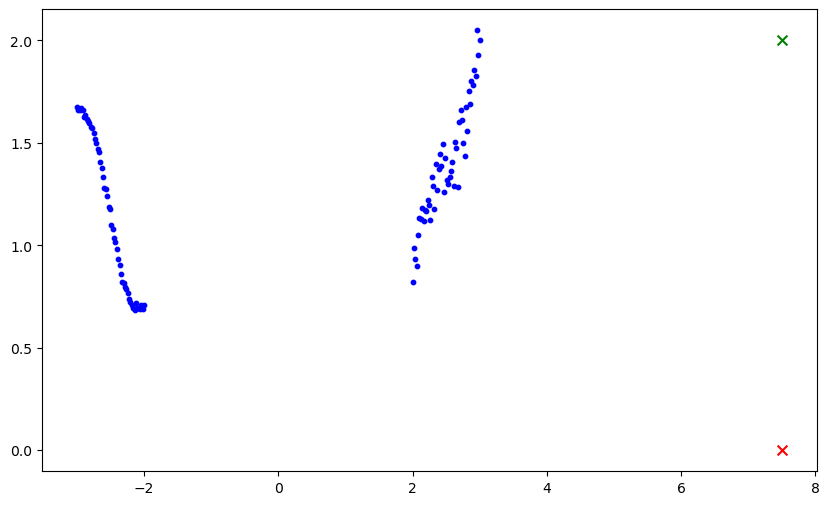

In [60]:
# plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test[0], y_test_1[0], color='red', label='UB', s = 50, marker = 'x') #
plt.scatter(X_test[1], y_test_2[0], color='green', label='LB', s = 50, marker = 'x') #
x_plot = torch.linspace(-10, 10, 200).reshape(-1,1)

preds_benn_valConstraint = [best_model_benn_valConstraint(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_benn_valConstraint = np.stack(preds_benn_valConstraint)
mean_benn_valConstraint = preds_benn_valConstraint.mean(axis=0)
ale_benn_valConstraint = best_model_benn_valConstraint(x_plot.to(device))[1].cpu().detach().numpy()
ale_benn_valConstraint = ale_benn_valConstraint**0.5
std_benn_valConstraint = preds_benn_valConstraint.std(axis=0)
ci_upper_benn_valConstraint = mean_benn_valConstraint + (std_benn_valConstraint)
ci_lower_benn_valConstraint = mean_benn_valConstraint - (std_benn_valConstraint)
ci_upper_ale_benn_valConstraint = mean_benn_valConstraint + (ale_benn_valConstraint)
ci_lower_ale_benn_valConstraint = mean_benn_valConstraint - (ale_benn_valConstraint)

# preds from baseline model
preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds)
mean = preds.mean(axis=0)
ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()
ale = ale**0.5
std = preds.std(axis=0)
ci_upper = mean + (std)
ci_lower = mean - (std)
ci_upper_ale = mean + (ale)
ci_lower_ale = mean - (ale)



plt.plot(x_plot, mean_benn_valConstraint, color='black', label='Constrained')
plt.fill_between(x_plot.squeeze(), ci_lower_benn_valConstraint.squeeze(), ci_upper_benn_valConstraint.squeeze(), color='red', alpha=0.5, label = 'Epi. Unc.')
plt.fill_between(x_plot.squeeze(), ci_lower_ale_benn_valConstraint.squeeze(), ci_upper_ale_benn_valConstraint.squeeze(), color='green', alpha=0.5, label = 'Ale. Unc.')
plt.plot(x_plot, mean, color='red', label='Unconstrained')
plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5)
plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='green')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# set text size for legend
plt.rc('legend', fontsize=10)
plt.show()

# plot std vs x_plot
plt.plot(x_plot, std_benn_valConstraint, color='red', label='Standard Deviation')
# fill_between the training data range - a vertical line
plt.axvline(x = -3, color = 'black', linestyle = '--', label = 'Training Data Range')
plt.axvline(x = -2, color = 'black', linestyle = '--')
plt.axvline(x = 2, color = 'black', linestyle = '--', label = 'Training Data Range')
plt.axvline(x = 3, color = 'black', linestyle = '--')



In [61]:

# get the value at the constraint using best_model_benn_valConstraint
y_pred_1 = [best_model_benn_valConstraint(X_test_1.unsqueeze(1).to(device))[0].cpu().detach().numpy() for _ in range(250)]    
y_pred_2 = [best_model_benn_valConstraint(X_test_2.unsqueeze(1).to(device))[0].cpu().detach().numpy() for _ in range(250)]
y_pred_1 = np.stack(y_pred_1).mean()
y_pred_2 = np.stack(y_pred_2).mean()

print('Value at Constraint 1:', y_pred_1)
print('Value at Constraint 2:', y_pred_2)
# infeasibility at the constraint
inf_1 = np.abs(y_pred_1 - y_test_1.numpy())
inf_2 = np.abs(y_pred_2 - y_test_2.numpy())
print('Infeasibility at Constraint 1:', inf_1)
print('Infeasibility at Constraint 2:', inf_2)
print('Mean infeasibility: ', np.mean([inf_1, inf_2]))

Value at Constraint 1: 1.0174446
Value at Constraint 2: 1.0173708
Infeasibility at Constraint 1: [1.0174446]
Infeasibility at Constraint 2: [0.9826292]
Mean infeasibility:  1.000037


#### VALUE CONSTRAINTS WITHOUT CONFLICTS

In [9]:
X_test_1 = torch.tensor([5.0]).float()
y_test_1 = torch.tensor([1.0]).float()
X_test_2 = torch.tensor([7.0]).float()
y_test_2 = torch.tensor([0.5]).float()
X_test = torch.tensor([[5.0, 7.0]]).float().reshape(-1, 1)

In [14]:
def value_constraint_fn_1(*args, **kwargs):
    pred = regressor_benn_valConstraint(X_test_1.unsqueeze(1).to(device))[0]
    return pred.squeeze()

def value_constraint_fn_2(*args, **kwargs):
    pred = regressor_benn_valConstraint(X_test_2.unsqueeze(1).to(device))[0]
    return pred.squeeze()


def var_at_value_constraint_fn(*args, **kwargs):
    ale = regressor_benn_valConstraint(X_test.to(device))[1]
    ale_std = ale**0.5
    return ale_std.squeeze()

value_constraint_1 = mdmm.EqConstraint(value_constraint_fn_1, y_test_1.to(device).squeeze())
value_constraint_2 = mdmm.EqConstraint(value_constraint_fn_2, y_test_2.to(device).squeeze())
# value_constraint = mdmm.BoundConstraintHard(value_constraint_fn, min = y_test[0].to(device), max = y_test[1].to(device))
var_at_value_constraint = mdmm.EqConstraint(var_at_value_constraint_fn, torch.tensor(0.001).to(device).squeeze())
mdmm_module = mdmm.MDMM([value_constraint_1, value_constraint_2, var_at_value_constraint])


In [15]:
# regressor_benn_valConstraint = UniformPriorHeteroscedasticRegressor(1, 2, 
#                                                                     uniform_low = -25.0,
#                                                                     uniform_high = 25.0,
#                                                                     posterior_mu_init = 0.0,
#                                                                     posterior_rho_init = -3.5).to(device)
regressor_benn_valConstraint = BayesianRegressor(1, 2).to(device)
criterion = nn.GaussianNLLLoss()
mse_ = nn.MSELoss(reduce = 'mean')
opt_benn_valConstraint = mdmm_module.make_optimizer(regressor_benn_valConstraint.parameters(), lr=1e-3)

In [16]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        preds, loss_total, loss_data, loss_compleixty = regressor_benn_valConstraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        mse_loss = mse_(preds[0], labels)
        # opt_benn_valConstraint.zero_grad()
        # loss_total.backward()
        # opt_benn_valConstraint.step()
        # if epoch%10==0:
        #     # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
        #     print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())
        
        mdmm_return = mdmm_module(loss_total)
        if (torch.hstack(mdmm_return.infs).abs().mean() + mse_loss) < best_loss:
            # check if loss is nan
            best_loss = torch.hstack(mdmm_return.infs).abs().mean() + mse_loss
            # best_model params are saved 
            best_model_benn_valConstraint = regressor_benn_valConstraint
            print('Best model updated at epoch:', epoch)
        opt_benn_valConstraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_valConstraint.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item(), 
                  'Value Constraint 1Infeasibility:', mdmm_return.infs[0].mean().item(), 
                  'Value Constraint 2 Infeasibility:', mdmm_return.infs[1].mean().item(),
                  'Var at Value Constraint Infeasibility:', mdmm_return.infs[2].mean().item())

Best model updated at epoch: 0
Epoch: 0 Total Loss: 27.648099899291992 Likelihood Loss: 1.4308125972747803 Complexity Loss: 26.217287063598633 Value Constraint 1Infeasibility: 1.3565547466278076 Value Constraint 2 Infeasibility: 1.054658055305481 Var at Value Constraint Infeasibility: -0.6437612771987915
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 27.18826675415039 Likelihood Loss: 0.9506482481956482 Complexity Loss: 26.237619400024414 Value Constraint 1Infeasibility: 0.8568769097328186 Value Constraint 2 Infeasibility: 0.3697930872440338 Var at Value Constraint Infeasibility: -0.673503041267395
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model u

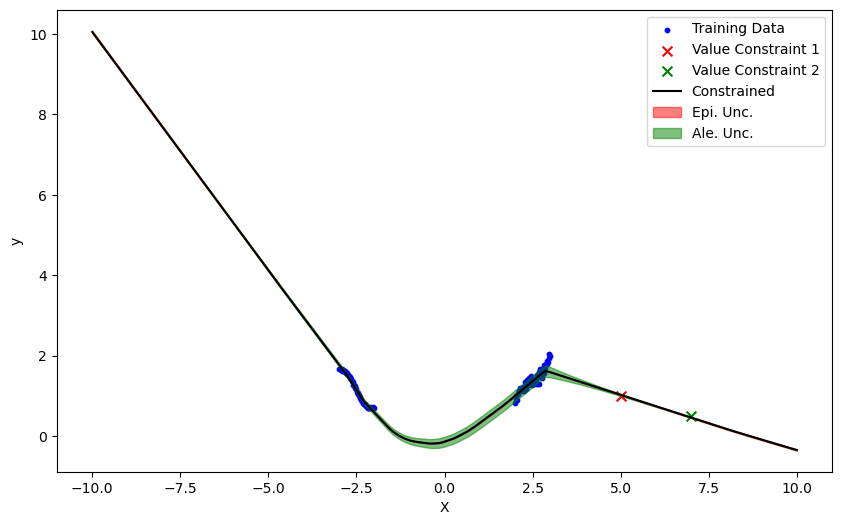

In [17]:
# plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test[0], y_test_1[0], color='red', label='Value Constraint 1', s = 50, marker = 'x') #
plt.scatter(X_test[1], y_test_2[0], color='green', label='Value Constraint 2', s = 50, marker = 'x') #
x_plot = torch.linspace(-10, 10, 200).reshape(-1,1)

preds_benn_valConstraint = [best_model_benn_valConstraint(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_benn_valConstraint = np.stack(preds_benn_valConstraint)
mean_benn_valConstraint = preds_benn_valConstraint.mean(axis=0)
ale_benn_valConstraint = best_model_benn_valConstraint(x_plot.to(device))[1].cpu().detach().numpy()
ale_benn_valConstraint = ale_benn_valConstraint**0.5
std_benn_valConstraint = preds_benn_valConstraint.std(axis=0)
ci_upper_benn_valConstraint = mean_benn_valConstraint + (std_benn_valConstraint)
ci_lower_benn_valConstraint = mean_benn_valConstraint - (std_benn_valConstraint)
ci_upper_ale_benn_valConstraint = mean_benn_valConstraint + (ale_benn_valConstraint)
ci_lower_ale_benn_valConstraint = mean_benn_valConstraint - (ale_benn_valConstraint)

# preds from the baseline model
# preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()
# ale = ale**0.5
# std = preds.std(axis=0)
# ci_upper = mean + (2*std)
# ci_lower = mean - (2*std)

# ci_upper_ale = mean + (2*ale)
# ci_lower_ale = mean - (2*ale)



plt.plot(x_plot, mean_benn_valConstraint, color='black', label='Constrained')
plt.fill_between(x_plot.squeeze(), ci_lower_benn_valConstraint.squeeze(), ci_upper_benn_valConstraint.squeeze(), color='red', alpha=0.5, label = 'Epi. Unc.')
plt.fill_between(x_plot.squeeze(), ci_lower_ale_benn_valConstraint.squeeze(), ci_upper_ale_benn_valConstraint.squeeze(), color='green', alpha=0.5, label = 'Ale. Unc.')

# plt.plot(x_plot, mean, color='red', label='Unconstrained')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5)
# plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='green', alpha=0.5)


plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# set text size for legend


plt.show()

# # plot std vs x_plot
# plt.plot(x_plot, std_benn_valConstraint, color='red', label='Standard Deviation')
# # fill_between the training data range - a vertical line
# plt.axvline(x = -3, color = 'black', linestyle = '--', label = 'Training Data Range')
# plt.axvline(x = -2, color = 'black', linestyle = '--')
# plt.axvline(x = 2, color = 'black', linestyle = '--', label = 'Training Data Range')
# plt.axvline(x = 3, color = 'black', linestyle = '--')



In [55]:

# get the value at the constraint using best_model_benn_valConstraint
y_pred_1 = [best_model_benn_valConstraint(X_test_1.unsqueeze(1).to(device))[0].cpu().detach().numpy() for _ in range(250)]    
y_pred_2 = [best_model_benn_valConstraint(X_test_2.unsqueeze(1).to(device))[0].cpu().detach().numpy() for _ in range(250)]
y_pred_1 = np.stack(y_pred_1).mean()
y_pred_2 = np.stack(y_pred_2).mean()

print('Value at Constraint 1:', y_pred_1)
print('Value at Constraint 2:', y_pred_2)
# infeasibility at the constraint
inf_1 = np.abs(y_pred_1 - y_test_1.numpy())
inf_2 = np.abs(y_pred_2 - y_test_2.numpy())
print('Infeasibility at Constraint 1:', inf_1)
print('Infeasibility at Constraint 2:', inf_2)
print('Mean infeasibility: ', np.mean([inf_1, inf_2]))

Value at Constraint 1: 1.0232223
Value at Constraint 2: 0.4586441
Infeasibility at Constraint 1: [0.02322233]
Infeasibility at Constraint 2: [0.04135591]
Mean infeasibility:  0.032289118


#### Bound value constraints

In [23]:
@variational_estimator
class UniformPriorHeteroscedasticRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 uniform_low = -25.0, uniform_high = 25.0, 
                 posterior_mu_init = 0.0, posterior_rho_init = -7.0):
        super().__init__()
        # Layers for prediction
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 100, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.ReLU(),
            BayesianLinear(100, output_dim, bias=True,
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise


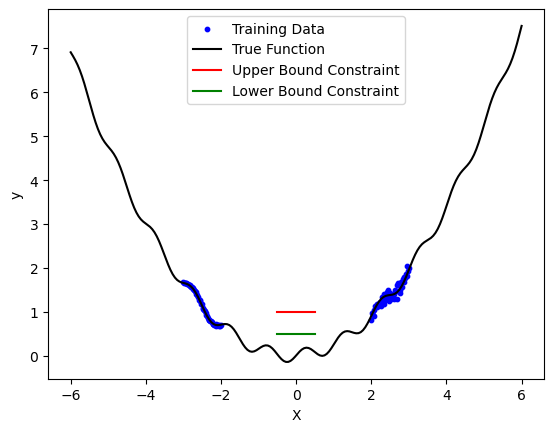

In [24]:
def bound_constraint_fn(*args, **kwargs):
    pred = regressor_benn_BoundConstraint(X_test.unsqueeze(1).to(device))[0]
    return pred.squeeze()

def bound_constraint_ground_truth(x):
    # the upper bound and lower bound are log
    ub = np.array([1.0 for _ in range(len(x))])
    lb = np.array([0.5 for _ in range(len(x))])
    return ub, lb

def variance_constraint_fn(*args, **kwargs):
    ale = regressor_benn_BoundConstraint(X_test.unsqueeze(1).to(device))[1]
    ale_std = ale**0.5
    return ale_std.squeeze()

def variance_constraint(x):
    return np.array([0.5 for _ in range(len(x))])

X_test = np.linspace(-0.5, 0.5, 5)
y_test = bound_constraint_ground_truth(X_test)
y_vars_test = variance_constraint(X_test)
# plot the training data, true function and the bound constraint 
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.plot(x_true, y_true, color = 'black', label='True Function')
plt.plot(X_test, y_test[0], color = 'red', label='Upper Bound Constraint')
plt.plot(X_test, y_test[1], color = 'green', label='Lower Bound Constraint')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(np.vstack(y_test)).float().to(device)
y_vars_test = torch.from_numpy(y_vars_test).float().to(device)

regressor_benn_BoundConstraint = BayesianRegressor(1, 2).to(device)
criterion = nn.GaussianNLLLoss()

n = y_test.shape[1]

# n bound constraints
bound_constraints = [mdmm.BoundConstraintHard(bound_constraint_fn, min = y_test[1][i].item(), max = y_test[0][i].item()) for i in range(n)]
variance_constraints = [mdmm.EqConstraint(variance_constraint_fn, y_vars_test[i].item()) for i in range(n)]
mdmm_module = mdmm.MDMM(bound_constraints)



opt_benn_BoundConstraint = mdmm_module.make_optimizer(regressor_benn_BoundConstraint.parameters(), lr=1e-3)

In [36]:
best_loss = 1e9
mse_loss = nn.MSELoss(reduction = 'sum')
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_benn_BoundConstraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        mdmm_return = mdmm_module(loss_total)
        mse_risk = mse_loss(regressor_benn_BoundConstraint(datapoints)[0].detach(), labels)
        if (torch.hstack(mdmm_return.infs).abs().mean() + mse_risk) < best_loss:
            # check if loss is nan
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model_benn_BoundConstraint = regressor_benn_BoundConstraint
            print('Best model updated at epoch:', epoch)
        opt_benn_BoundConstraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_BoundConstraint.step()
    

    if epoch%10==0:
        # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
        print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'MSE Loss:', mse_risk.item(), 'Complexity Loss:', loss_compleixty.item(), 
                'Bound Constraint Infeasibility:', mdmm_return.infs[0].mean().item(), 'Variance Constraint Infeasibility:', mdmm_return.infs[1].mean().item())
    if mdmm_return.infs[0].mean().item() < 0.001 and mdmm_return.infs[1].mean().item() < 0.001 and mse_risk.item() < 0.001:
        print('Data, Bound and Variance Constraints Satisfied')
        best_model_benn_BoundConstraint = regressor_benn_BoundConstraint
        break

Best model updated at epoch: 0
Epoch: 0 Total Loss: 24.078632354736328 MSE Loss: 0.6232782602310181 Complexity Loss: 26.291976928710938 Bound Constraint Infeasibility: 0.0 Variance Constraint Infeasibility: 0.0
Epoch: 10 Total Loss: 24.055782318115234 MSE Loss: 0.6215648651123047 Complexity Loss: 26.2982120513916 Bound Constraint Infeasibility: 0.0 Variance Constraint Infeasibility: 0.0
Epoch: 20 Total Loss: 23.915430068969727 MSE Loss: 0.6253432035446167 Complexity Loss: 26.15675163269043 Bound Constraint Infeasibility: 0.0 Variance Constraint Infeasibility: 0.0
Epoch: 30 Total Loss: 23.966930389404297 MSE Loss: 0.6636091470718384 Complexity Loss: 26.190420150756836 Bound Constraint Infeasibility: 0.0 Variance Constraint Infeasibility: 0.0
Epoch: 40 Total Loss: 23.758716583251953 MSE Loss: 0.6212319135665894 Complexity Loss: 25.99981117248535 Bound Constraint Infeasibility: 0.0 Variance Constraint Infeasibility: 0.0
Epoch: 50 Total Loss: 23.98830223083496 MSE Loss: 0.6411340832710266 

KeyboardInterrupt: 

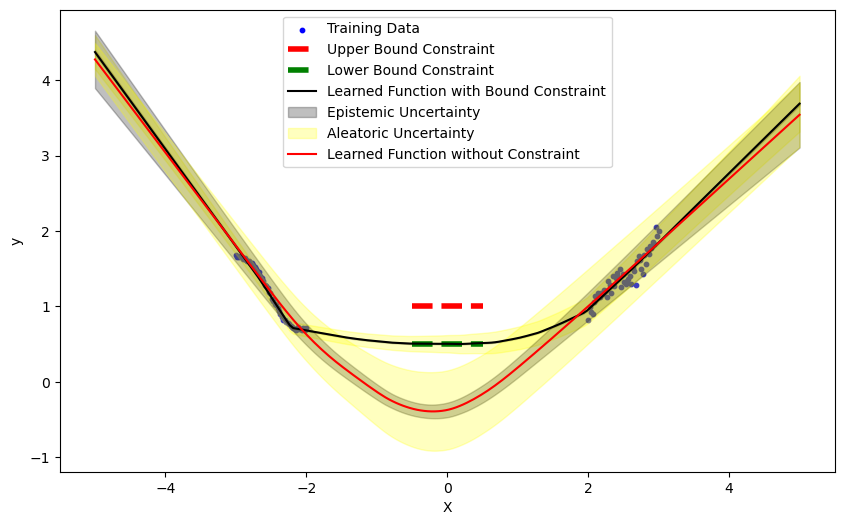

In [37]:
# plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.plot(X_test.cpu(), y_test[0].cpu(), color = 'red', label='Upper Bound Constraint', linestyle = '--', linewidth = 4)
plt.plot(X_test.cpu(), y_test[1].cpu(), color = 'green', label='Lower Bound Constraint', linestyle = '--', linewidth = 4)
x_plot = torch.linspace(-5, 5, 200).reshape(-1,1)

preds_benn_BoundConstraint = [regressor_benn_BoundConstraint(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_benn_BoundConstraint = np.stack(preds_benn_BoundConstraint)
mean_benn_BoundConstraint = preds_benn_BoundConstraint.mean(axis=0)
ale_benn_BoundConstraint = regressor_benn_BoundConstraint(x_plot.to(device))[1].cpu().detach().numpy()**0.5
std_benn_BoundConstraint = preds_benn_BoundConstraint.std(axis=0)
ci_upper_benn_BoundConstraint = mean_benn_BoundConstraint + (2*std_benn_BoundConstraint)
ci_lower_benn_BoundConstraint = mean_benn_BoundConstraint - (2*std_benn_BoundConstraint)

ci_upper_ale_benn_BoundConstraint = mean_benn_BoundConstraint + (2*ale_benn_BoundConstraint)
ci_lower_ale_benn_BoundConstraint = mean_benn_BoundConstraint - (2*ale_benn_BoundConstraint)

# preds for the baseline model
preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds)
mean = preds.mean(axis=0)
ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()**0.5
std = preds.std(axis=0)
ci_upper = mean + (2*std)
ci_lower = mean - (2*std)
ci_upper_ale = mean + (2*ale)
ci_lower_ale = mean - (2*ale)


plt.plot(x_plot, mean_benn_BoundConstraint, color='black', label='Learned Function with Bound Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn_BoundConstraint.squeeze(), ci_upper_benn_BoundConstraint.squeeze(), color='black', alpha=0.25, label = 'Epistemic Uncertainty')
plt.fill_between(x_plot.squeeze(), ci_lower_ale_benn_BoundConstraint.squeeze(), ci_upper_ale_benn_BoundConstraint.squeeze(), color='yellow', alpha=0.25, label = 'Aleatoric Uncertainty')
plt.plot(x_plot, mean, color='red', label='Learned Function without Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='black', alpha=0.25)
plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='yellow', alpha = 0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()


In [41]:
# bound constraint infeasibility
y_pred = [best_model_benn_BoundConstraint(X_test.unsqueeze(1).to(device))[0] for _ in range(250)]
y_pred = torch.stack(y_pred).mean(axis = 0)
infs = y_pred.clamp(min=y_test[1][i].item(), max=y_test[0][i].item()) - y_pred
print('Bound Constraint Infeasibility:', infs.mean().item())

Bound Constraint Infeasibility: 0.0


In [25]:
plt.savefig('results_benn_1d_regression/learned_function_bound_constraint_withVarConstraint.png')

<Figure size 640x480 with 0 Axes>

### Incorporation of derivative constraints

In [93]:
def derivative_constraint_fn(*args, **kwargs):
	dx = args[1]
	pred = regressor_benn_derivativeConstraint(X_test.to(device))[0]
	d_pred = (pred[1] - pred[0])/(2*dx)
	return d_pred.squeeze()
	# return (regressor_benn_derivativeConstraint(X_test.unsqueeze(1).to(device) + dx)[0] - regressor_benn_derivativeConstraint(X_test.unsqueeze(1).to(device) - dx)[0])/(2*dx)

# create model
regressor_benn_derivativeConstraint = BayesianRegressor(1, 2).to(device)
criterion = nn.GaussianNLLLoss()
X_test = torch.tensor([[9.4], [9.6]]).float().to(device)
y_test = torch.tensor([0.0]).float().to(device)
dx = (X_test[1] - X_test[0]) / 2

derivative_constraint = mdmm.EqConstraint(derivative_constraint_fn, y_test.to(device).squeeze())
mdmm_module = mdmm.MDMM([derivative_constraint])
opt_benn_derivativeConstraint = mdmm_module.make_optimizer(regressor_benn_derivativeConstraint.parameters(), lr=1e-3)



In [94]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_benn_derivativeConstraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        mdmm_return = mdmm_module(loss_total, dx)
        if loss_data.item() < best_loss:
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model_benn_derivativeConstraint = regressor_benn_derivativeConstraint
            print('Best model updated at epoch:', epoch)
        opt_benn_derivativeConstraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_derivativeConstraint.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item(), 
                  'Derivative Constraint Infeasibility:', mdmm_return.infs[0].mean().item())

Best model updated at epoch: 0
Epoch: 0 Total Loss: 27.485706329345703 Likelihood Loss: 1.6636228561401367 Complexity Loss: 25.822084426879883 Derivative Constraint Infeasibility: 0.03594444319605827
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 27.180429458618164 Likelihood Loss: 1.0873122215270996 Complexity Loss: 26.093116760253906 Derivative Constraint Infeasibility: -0.018422607332468033
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model updated at epoch: 14
Best model updated at epoch: 15
Best model updated at epoch: 16
Best model updated at epoch: 17
Best model updated at epoch: 18
Best model updated at epoch: 19
Best model updated at epoch: 

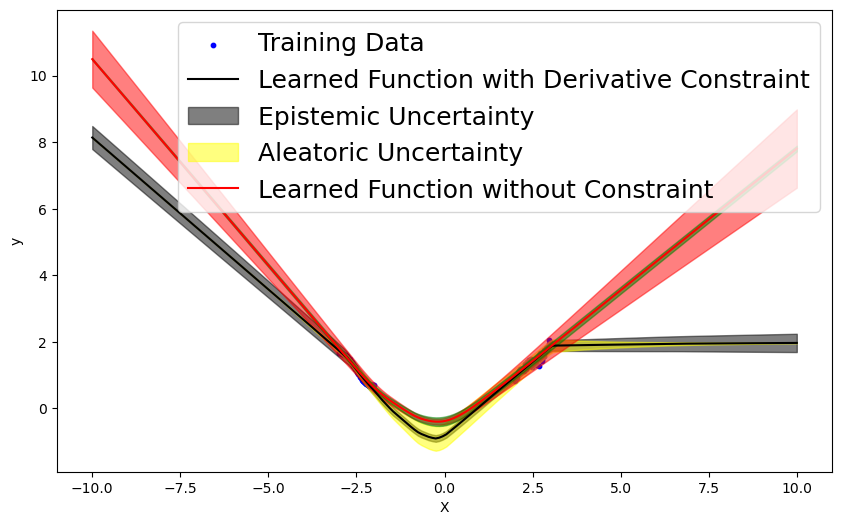

In [85]:
# plotting 
best_model_benn_derivativeConstraint.eval()
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
x_plot = torch.linspace(-10, 10, 200).reshape(-1,1)

preds_benn_derivativeConstraint = [best_model_benn_derivativeConstraint(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_benn_derivativeConstraint = np.stack(preds_benn_derivativeConstraint)
mean_benn_derivativeConstraint = preds_benn_derivativeConstraint.mean(axis=0)
ale_benn_derivativeConstraint = best_model_benn_derivativeConstraint(x_plot.to(device))[1].cpu().detach().numpy()
ale_benn_derivativeConstraint = ale_benn_derivativeConstraint**0.5
std_benn_derivativeConstraint = preds_benn_derivativeConstraint.std(axis=0)**0.5
ci_upper_benn_derivativeConstraint = mean_benn_derivativeConstraint + (2*std_benn_derivativeConstraint)
ci_lower_benn_derivativeConstraint = mean_benn_derivativeConstraint - (2*std_benn_derivativeConstraint)
ci_upper_ale_benn_derivativeConstraint = mean_benn_derivativeConstraint + (2*ale_benn_derivativeConstraint)
ci_lower_ale_benn_derivativeConstraint = mean_benn_derivativeConstraint - (2*ale_benn_derivativeConstraint)

# preds from the baseline model
preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds)
mean = preds.mean(axis=0)
ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()
std = preds.std(axis=0)
ci_upper = mean + (2*std)
ci_lower = mean - (2*std)
ci_upper_ale = mean + (2*ale)
ci_lower_ale = mean - (2*ale)


plt.plot(x_plot, mean_benn_derivativeConstraint, color='black', label='Learned Function with Derivative Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn_derivativeConstraint.squeeze(), ci_upper_benn_derivativeConstraint.squeeze(), color='black', alpha=0.5, label = 'Epistemic Uncertainty')
plt.fill_between(x_plot.squeeze(), ci_lower_ale_benn_derivativeConstraint.squeeze(), ci_upper_ale_benn_derivativeConstraint.squeeze(), color='yellow', alpha=0.5, label = 'Aleatoric Uncertainty')
plt.plot(x_plot, mean, color='red', label='Learned Function without Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5)
plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='green', alpha = 0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# set text size for legend
plt.rc('legend', fontsize=18)
plt.show()


In [98]:
# get the value at the constraint using best_model_benn_valConstraint
y_pred_1 = [best_model_benn_derivativeConstraint(X_test[0].unsqueeze(1).to(device))[0].cpu().detach().numpy() for _ in range(500)]    
y_pred_2 = [best_model_benn_derivativeConstraint(X_test[1].unsqueeze(1).to(device))[0].cpu().detach().numpy() for _ in range(500)]
y_pred_1 = np.stack(y_pred_1).mean()
y_pred_2 = np.stack(y_pred_2).mean()

# compute derivative
dx = ((X_test[1] - X_test[0]) / 2 ).item()
dy_pred = (y_pred_2 - y_pred_1)/(2*dx)

# infeasibility at the constraint
inf = np.abs(dy_pred - y_test.item())
print('Derivative infeasibility:', inf)


Derivative infeasibility: 0.010305603768906522


### Incorporation of soft bound constraints

In [45]:
def min_constraint_fn(*args, **kwargs):
    pred = regressor_benn_minConstraint(x)[0]
    return pred.squeeze()

def min_constraint_ground_truth(x):
    return np.array([0.5 for _ in range(len(x))])

X_test = np.linspace(5,8,5)
y_test = min_constraint_ground_truth(X_test)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

regressor_benn_minConstraint = UniformPriorHeteroscedasticRegressor(1, 2).to(device)
criterion = nn.GaussianNLLLoss()

min_constraints = [mdmm.MinConstraint(min_constraint_fn, y_test[i].item()) for i in range(len(X_test))]
mdmm_module = mdmm.MDMM(min_constraints)
opt_benn_minConstraint = mdmm_module.make_optimizer(regressor_benn_minConstraint.parameters(), lr=1e-3)


In [47]:
# training
best_loss = 1e9
mse_loss = nn.MSELoss(reduction = 'sum')

for epoch in range(4000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_benn_minConstraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        mdmm_return = mdmm_module(loss_total)
        mse_risk = mse_loss(regressor_benn_minConstraint(datapoints)[0].detach(), labels)
        if loss_data.item() < best_loss:
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model_benn_minConstraint = regressor_benn_minConstraint
            print('Best model updated at epoch:', epoch)
        opt_benn_minConstraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_minConstraint.step()
    if epoch%10==0:
        # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
        print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'MSE Loss:', mse_risk.item(), 'Complexity Loss:', loss_compleixty.item(), 
                'Min Constraint Infeasibility:', mdmm_return.infs[0].mean().item())
    if mdmm_return.infs[0].mean().item() < 0.001 and mse_risk.item() < 0.001:
        print('Data and Min Constraints Satisfied')
        best_model_benn_minConstraint = regressor_benn_minConstraint
        break

RuntimeError: output with shape [] doesn't match the broadcast shape [5]

### Incorporation of Variance Constraint - Epistemic Uncertainty

In [33]:
@variational_estimator
class EpistemicRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 uniform_low = -25.0, uniform_high = 25.0, 
                 posterior_mu_init = 0.0, posterior_rho_init = -7.0):
        super().__init__()
        # Layers for prediction
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 100, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.ReLU(),
            BayesianLinear(100, output_dim, bias=True,
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise


In [42]:
X_test = torch.tensor([0.0]).float().to(device)
y_test = torch.tensor([5.0]).float().to(device) 

regressor_epistemic_min_constraint = EpistemicRegressor(1, 2).to(device)

epistemic_min_constraint = mdmm.EqConstraint(epistemic_min_constraint_fn, y_test.to(device))
mdmm_module = mdmm.MDMM([epistemic_min_constraint])
opt_benn_epistemic_min_constraint = mdmm_module.make_optimizer(regressor_epistemic_min_constraint.parameters(), lr=1e-3)


In [43]:
best_loss = 1e9
for epoch in range(4000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor_epistemic_min_constraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        mdmm_return = mdmm_module(loss_total)
        if loss_data.item() < best_loss:
            # check if loss is nan
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model_epistemic_min_constraint = regressor_epistemic_min_constraint
            print('Best model updated at epoch:', epoch)
        opt_benn_epistemic_min_constraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_epistemic_min_constraint.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item(), 
                  'Epistemic Min Constraint Infeasibility:', mdmm_return.infs[0].mean().item())

Best model updated at epoch: 0
Epoch: 0 Total Loss: 39.462257385253906 Likelihood Loss: 1.440140962600708 Complexity Loss: 38.022117614746094 Epistemic Min Constraint Infeasibility: 4.998815059661865
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 39.06597137451172 Likelihood Loss: 0.955022394657135 Complexity Loss: 38.1109504699707 Epistemic Min Constraint Infeasibility: 4.998271465301514
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model updated at epoch: 14
Best model updated at epoch: 15
Best model updated at epoch: 16
Best model updated at epoch: 17
Best model updated at epoch: 18
Best model updated at epoch: 19
Best model updated at epoch: 20
Ep

KeyboardInterrupt: 

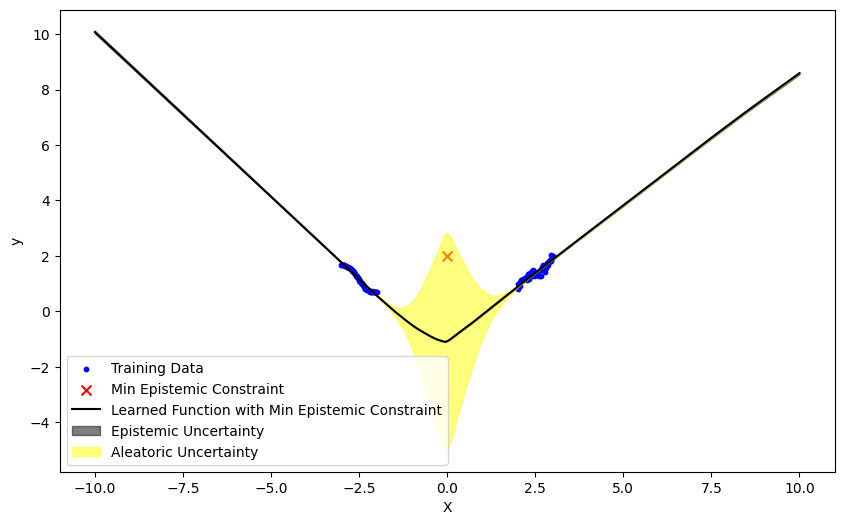

In [20]:
# plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test.cpu(), y_test.cpu(), color='red', label='Min Epistemic Constraint', s = 50, marker = 'x') #
x_plot = torch.linspace(-10, 10, 200).reshape(-1,1)

preds_epistemic_min_constraint = [best_model_epistemic_min_constraint(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_epistemic_min_constraint = np.stack(preds_epistemic_min_constraint)
mean_epistemic_min_constraint = preds_epistemic_min_constraint.mean(axis=0)
ale_epistemic_min_constraint = best_model_epistemic_min_constraint(x_plot.to(device))[1].cpu().detach().numpy()
std_epistemic_min_constraint = preds_epistemic_min_constraint.std(axis=0)
ci_upper_epistemic_min_constraint = mean_epistemic_min_constraint + (2*std_epistemic_min_constraint)
ci_lower_epistemic_min_constraint = mean_epistemic_min_constraint - (2*std_epistemic_min_constraint)

ci_upper_ale_epistemic_min_constraint = mean_epistemic_min_constraint + (ale_epistemic_min_constraint)
ci_lower_ale_epistemic_min_constraint = mean_epistemic_min_constraint - (ale_epistemic_min_constraint)

plt.plot(x_plot, mean_epistemic_min_constraint, color='black', label='Learned Function with Min Epistemic Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_epistemic_min_constraint.squeeze(), ci_upper_epistemic_min_constraint.squeeze(), color='black', alpha=0.5, label = 'Epistemic Uncertainty')
plt.fill_between(x_plot.squeeze(), ci_lower_ale_epistemic_min_constraint.squeeze(), ci_upper_ale_epistemic_min_constraint.squeeze(), color='yellow', alpha=0.5, label = 'Aleatoric Uncertainty')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
